## Definitions for processing the image and determining number of channels for conversion.

In [1]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import numpy as np
import cv2 
#
def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Convert RGBA images to RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        print("------------------------------------------------------------------------------------")
        print("Running rgba2rgb")
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
#
#
def rgb2grey(rgb, negative = 0, withHists = False):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debugHere = False
    #
    if debugHere:
        print("------------------------------------------------------------------------------------")
        print("Running rgb2grey")
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    if withHists:
        print(" ")
        print("Max intensities red",np.amax(r),"blue",np.amax(b),"green",np.amax(g))
        print(" ")
        nBins = int(256/8)
        nBins = 256
        plt.figure(figsize = (10, 9))
        plt.subplot(4, 1, 1)
        plt.hist(np.ravel(r), bins = nBins, color = 'r')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 2)
        plt.hist(np.ravel(g), bins = nBins, color = 'g')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 3)
        plt.hist(np.ravel(b), bins = nBins, color = 'b')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 4)
        plt.hist(np.ravel(grey), bins = nBins, color = 'k')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.tight_layout()
        plt.show()
    #
    return np.asarray(grey, dtype = np.uint8)
#
#
#
def ceilDiv(a, b):
    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling
#
#
#
def processRawImage(imgRaw):
    '''
    Convert images of various types to greyscale, removing any hot pixels and rescaling so use full 
    range (0...255) for image without hot pixels 
    '''
    #
    import sys
    import numpy as np
    import scipy.ndimage as ndimage
    import matplotlib.pyplot as plt
    %matplotlib inline
    # 
    # Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
    if len(imgRaw.shape) == 3:
        nRows = imgRaw.shape[0] 
        nCols = imgRaw.shape[1]
        nDepth = imgRaw.shape[2]
    elif len(imgRaw.shape) == 2:
        nRows = imgRaw.shape[0] 
        nCols = imgRaw.shape[1]
        nDepth = 1
    else:
        print("Unexpected image format, imgRaw.shape =",imgRaw.shape)
        sys.exit()
    #
    imgGrey = np.zeros((nRows, nCols))
    #
    # Determine image format and process accordingly
    if nDepth == 4:
        imgRGB = rgba2rgb(imgRaw)
        imgGrey = rgb2grey(imgRGB, 0, withHists)
    elif nDepth == 3:
        imgRGB = imgRaw
        imgGrey = rgb2grey(imgRGB, 1, withHists)
    elif nDepth == 1:
        imgRGB = imgRaw
        imgGrey = imgRaw
    else:
        print(" ")
        print("Unexpected image depth",nDepth)
        sys.stop()
    #
    if imgGrey.dtype == 'uint16':
        imgGreyOut = cv2.convertScaleAbs(imgGrey, alpha = (255.0/65535.0))
    elif imgGrey.dtype == 'uint8':
        imgGreyOut = imgGrey
    else:
        print(" ")
        print("Unknown datatype in image",imgGrey.dtype)
        sys.exit()
    #
    return imgGreyOut, nRows, nCols
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
#print("Time since notebook start is",str(now - startNB))

Date and time  2021-10-29 13:40:27.202100
 
Date and time 2021-10-29 13:40:27.343557
Time since last check is 0:00:00.141457


## converting IF images

In [ ]:
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
# 
#################################################
# Read in bmp files in directory
#
convert = True
channel = '/DAPI'
#real_test_dir = '../../datasets/comet/test/*.bmp'  #where the test directory is comapred to this notebook location
root_dir = '../CometImages/IF210616/Collated/'
all_dir = sorted(glob.glob(root_dir+'*'))
print("all_dir: ",all_dir)
nDir = len(all_dir)
# loop over all directories
for nD in range(0, nDir):
    name_dir = [os.path.basename(x) for x in sorted(glob.glob(all_dir[nD]))]
    print("name_dir is: ", name_dir[0])
    #image_dir = all_dir[nD] + '/*.tif'  #where the image directory is - find all tif files here
    image_dir = all_dir[nD] + channel + '/*.tif'  #where the image directory is - find all tif files here
    print("image_dir is: ", image_dir)
    fileList= sorted(glob.glob(image_dir))  #whole file path, as set in above line
    print("Files read in (whole path) are", fileList)
    #
    fileNames = [os.path.basename(x) for x in sorted(glob.glob(image_dir))]  #only file name with extension
    #print("\nFile names (with extension) are:", fileNames)
    #
    nFiles = len(fileNames)
    print("\n",nFiles, " files will be analysed")
    #
    fileNamesSplit = np.empty((nFiles), dtype = 'object')


    for n in range (0, nFiles):
        x = fileNames[n]
        fileNamesSplit[n] = os.path.splitext(x)[0]   #remove extension from file name
    #print("fileNamesSplit is: ", fileNamesSplit)
    ##
    write = False
    #
    if convert==True:
        for n in range (0, 1):
            imgTif = Image.open(fileList[n], mode='r')
            #plt.imshow(imgTif)
            #plt.show()
            imgArr = np.asarray(imgTif)
            print(imgArr.shape)
            outfile = all_dir[nD] + channel + '/bmp/' + name_dir[0] + '00' + str(n) + '.bmp'
            #outfile = root_dir + folder_dir +'/bmp/' + name_dir[0] + '00' +str(n)+ '.bmp'
            if write == True:
                plt.imsave(outfile, imgArr)


print("complete")

## converting CA images

In [2]:
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
# 
#################################################
# Read in files from directory
#
convert = True
#real_test_dir = '../../datasets/comet/test/*.bmp'  #where the test directory is comapred to this notebook location
root_dir = '../CometImages/CA210819/Collated/'
all_dir = sorted(glob.glob(root_dir+'*'))
print("all_dir: ",all_dir)
nDir = len(all_dir)
# loop over all directories
for nD in range(0, nDir):
    name_dir = [os.path.basename(x) for x in sorted(glob.glob(all_dir[nD]))]
    print("name_dir is: ", name_dir[0])
    image_dir = all_dir[nD] + '/*.tif'  #where the image directory is - find all tif files here
    print("image_dir is: ", image_dir)
    fileList= sorted(glob.glob(image_dir))  #whole file path, as set in above line
    print("Files read in (whole path) are", fileList)
    #
    fileNames = [os.path.basename(x) for x in sorted(glob.glob(image_dir))]  #only file name with extension
    #print("\nFile names (with extension) are:", fileNames)
    #
    nFiles = len(fileNames)
    print("\n",nFiles, " files will be analysed")
    #
    fileNamesSplit = np.empty((nFiles), dtype = 'object')


    for n in range (0, nFiles):
        x = fileNames[n]
        fileNamesSplit[n] = os.path.splitext(x)[0]   #remove extension from file name
    #print("fileNamesSplit is: ", fileNamesSplit)
    ##
    write = True
    #
    if convert==True:
        for n in range (0, nFiles):
            file = fileList[n]
            imgRaw = plt.imread(file)
            imgGrey, nRows, nCols = processRawImage(imgRaw)
            #
            print(" ")
            print("Dynamic range from",np.amin(imgGrey),"to",np.amax(imgGrey))
            print("Type of image file is",imgGrey.dtype)
            print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols)
            print("image shape is: ", imgGrey.shape)
            #
            outfile = all_dir[nD] + '/bmp/' + name_dir[0] + '00' + str(n) + '.bmp'
            #
            if write == True:
                cv2.imwrite(outfile, imgGrey)
"""         
            
            nBins = 65536
            pixMin = np.min(imgArr)
            pixMax = np.max(imgArr)
            print("min and max pixel values of imag array are: ", pixMin, pixMax)
            plt.figure(figsize = (12, 9))
            plt.title("intensity histograms for tif file")
            plt.subplot(1, 1, 1)
            plt.hist(imgArr.flatten(), bins = nBins, color = 'k')
            plt.yscale("log")
            plt.xlim(-1, 64099)
            plt.show()
            #
            #rescale pixel instensities and show image
            imgScale = (imgArr / pixMax) * 255 
            plt.figure(figsize=(16,8))
            plt.imshow(imgScale)
            plt.show()
            #
            outfile = all_dir[nD] + '/bmp/' + name_dir[0] + '00' + str(n) + '.bmp'
            if write == True:
                cv2.imwrite(outfile, imgArr)

"""
print("complete")

all_dir:  ['../CometImages/CA210819/Collated/2GyAfirst', '../CometImages/CA210819/Collated/2GyAsecond', '../CometImages/CA210819/Collated/4GyBfirst', '../CometImages/CA210819/Collated/4GyBsecond', '../CometImages/CA210819/Collated/4GyCfirst', '../CometImages/CA210819/Collated/4GyCsecond', '../CometImages/CA210819/Collated/8GyBfirst', '../CometImages/CA210819/Collated/8GyBsecond', '../CometImages/CA210819/Collated/ControlAfirst', '../CometImages/CA210819/Collated/ControlAsecond']
name_dir is:  2GyAfirst
image_dir is:  ../CometImages/CA210819/Collated/2GyAfirst/*.tif
Files read in (whole path) are []

 0  files will be analysed
name_dir is:  2GyAsecond
image_dir is:  ../CometImages/CA210819/Collated/2GyAsecond/*.tif
Files read in (whole path) are []

 0  files will be analysed
name_dir is:  4GyBfirst
image_dir is:  ../CometImages/CA210819/Collated/4GyBfirst/*.tif
Files read in (whole path) are []

 0  files will be analysed
name_dir is:  4GyBsecond
image_dir is:  ../CometImages/CA210819/

## exploring why grey conversion of the bitmap images is cutting off the intensity

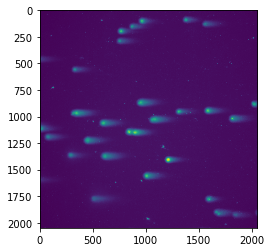

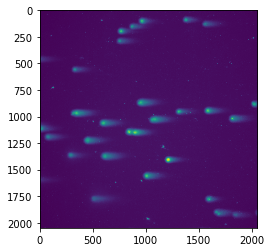

tiff file shape is:  (2048, 2048)
bmp shape is:  (2048, 2048)
min and max pixel values of bmp array are:  1258 47502
min and max pixel values of tif array are:  1258 47502


'\nplt.title("bmp instenisty histogram")\nplt.hist(bmpArr.flatten(), bins = np.arange(0, bmpMax, 1), color = \'y\')\nplt.yscale("log")\nplt.xlim(-1, 256)\nplt.show()\n#\nplt.title("tif intensity histogram")\nplt.hist(imgRawTIF.flatten(), bins = np.arange(0, tifMax, 1), color = \'k\')\nplt.yscale("log")\nplt.xlim(-1, tifMax)\nplt.show()\n'

In [10]:
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
from PIL import Image
import cv2
import skimage.io as skio
import matplotlib.pyplot as plt
%matplotlib inline

imFileBMP = "../CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00023.png"
imFileTIF = "../CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00023.tif"
#
#imgRawBMP = plt.imread(imFileBMP)
imgRawBMP = skio.imread(imFileBMP)
#imgRawTIF = skio.imread(imFileTIF, plugin="tifffile")
imgRawTIF = skio.imread(imFileTIF)

#
plt.imshow(imgRawBMP)
plt.show()
plt.imshow(imgRawTIF)
plt.show()
#
bmpArr = np.asarray(imgRawBMP) #4 channels RGBA
#bmpArr = bmpArrRGBA[:,:,0] #1 channel
print("tiff file shape is: ", imgRawTIF.shape)
#print("bmp RGB shape is: ", bmpArrRGBA.shape)
print("bmp shape is: ", bmpArr.shape)
#print("tif: ", imgRawTIF[1750,125:250])
#
#print("bmp: ", bmpArr[1750, 125:250])

bmpMin = np.min(bmpArr)
bmpMax = np.max(bmpArr)
#tifArr = np.asarray(imgRawTIF)
tifMax = np.max(imgRawTIF)
tifMin = np.min(imgRawTIF)
#
print("min and max pixel values of bmp array are: ", bmpMin, bmpMax)
print("min and max pixel values of tif array are: ", tifMin, tifMax)
#
"""
plt.title("bmp instenisty histogram")
plt.hist(bmpArr.flatten(), bins = np.arange(0, bmpMax, 1), color = 'y')
plt.yscale("log")
plt.xlim(-1, 256)
plt.show()
#
plt.title("tif intensity histogram")
plt.hist(imgRawTIF.flatten(), bins = np.arange(0, tifMax, 1), color = 'k')
plt.yscale("log")
plt.xlim(-1, tifMax)
plt.show()
"""

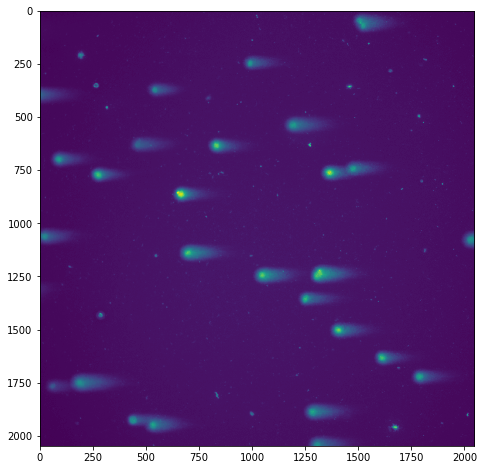

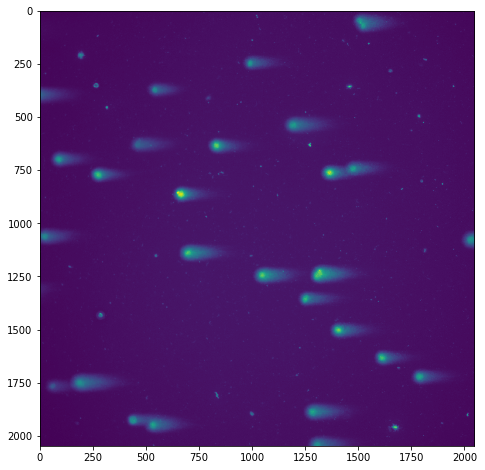

tiff file shape is:  (2048, 2048)
bmp RGB shape is:  (2048, 2048)
bmp shape is:  (2048, 2048)

min and max pixel values of bmp array are:  6 190
min and max pixel values of tif array are:  1542 48823


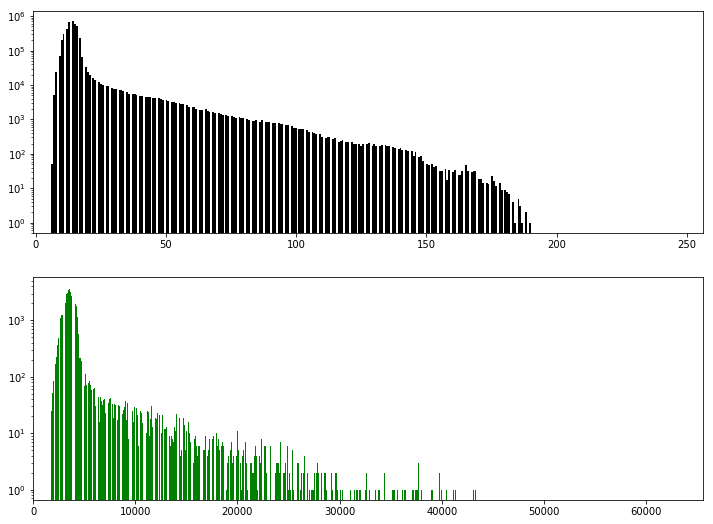

In [5]:
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
from PIL import Image
import cv2
import skimage.io as skio
import matplotlib.pyplot as plt
%matplotlib inline

imFileBMP = "../CometImages/CA210609/Collated/4GyB/bmp/4GyB000.bmp"
imFileTIF = "../CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_000.tif"
#
imgRawBMP = plt.imread(imFileBMP)
#imgRawTIF = plt.imread(imFileTIF)
imgRawTIF = skio.imread(imFileTIF, plugin="tifffile")
#
plt.figure(figsize=(12,8))
plt.imshow(imgRawBMP)
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(imgRawTIF)
plt.show()
#
#bmpArrRGBA = np.asarray(imgRawBMP) #4 channels RGBA
print("tiff file shape is: ", imgRawTIF.shape)
#print("bmp RGB shape is: ", bmpArrRGBA.shape)
print("bmp shape is: ", imgRawBMP.shape)
#print("tif: ", imgRawTIF[1750,125:250])`
#
#print("bmp: ", bmpArr[1750, 125:250])

bmpMin = np.min(imgRawBMP)
bmpMax = np.max(imgRawBMP)
#tifArr = np.asarray(imgRawTIF)
tifMax = np.max(imgRawTIF)
tifMin = np.min(imgRawTIF)
print("\nmin and max pixel values of bmp array are: ", bmpMin, bmpMax)
print("min and max pixel values of tif array are: ", tifMin, tifMax)
#
nBinsBMP = 256
nBinsTIF = 65536

plt.figure(figsize = (12, 9))
plt.title("intensity histograms for 4GyB000: bmp and tif")
plt.subplot(2, 1, 1)
plt.hist(imgRawBMP.flatten(), bins = nBinsBMP, color = 'k')
plt.yscale("log")
plt.xlim(-1, nBinsBMP)
plt.subplot(2, 1, 2)
plt.hist(imgRawTIF.flatten(), bins = nBinsTIF, color = 'g')
plt.yscale("log")
plt.xlim(-1, nBinsTIF)
plt.show()

In [ ]:
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
from PIL import Image
import cv2
import skimage.io as skio
import matplotlib.pyplot as plt
%matplotlib inline
imFileTIF = "../CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_000.tif"

imgGreyOut = cv2.convertScaleAbs(imgGrey, alpha = (255.0/65535.0))